## Package Imports

In [1]:
import pandas as pd, numpy as np
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
import shap
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from mlxtend.evaluate import bootstrap
from numpy import format_float_scientific
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from shap.plots.waterfall import waterfall_plot
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.rcParams['figure.dpi']=300

## Misc. Functions

In [2]:
def extract_ys(Y):
    return Y[:,0], Y[:,1]

def auc(Y):
    y_true, y_pred=extract_ys(Y)
    return roc_auc_score(y_true, y_pred)

def return_bootstrap_results(results,fn,round_place=1):
    Y=results[['y_true','y_pred_probs']].values
    original, std_err, ci_bounds = bootstrap(Y, num_rounds=1000,
                                             func=fn,
                                             ci=0.95,
                                             seed=123)
    std_err=format_float_scientific(std_err,round_place)
    if float(std_err) >= 0.001:
        std_err=float(std_err)
    
    return "{}±{}".format(float(format_float_scientific(original,round_place)),2*std_err)

def run_shap(X_train, X_test, best_estimator, model_type='tree', explainer_options={}, get_shap_values_options={}, overall=False):
    
    shap.initjs()
    
    shap_model={'tree':shap.TreeExplainer,'kernel':shap.KernelExplainer,'linear':shap.LinearExplainer}[model_type]

    explainer = shap_model(best_estimator, X_train,**explainer_options)

    shap_values = explainer.shap_values(X_test,**get_shap_values_options)
    
    if model_type=='tree' and best_estimator.__class__.__name__!='XGBClassifier':
        shap_values=np.array(shap_values)[1,...]

    shap.summary_plot(shap_values, X_test,feature_names=list(X_train), plot_type='bar' if overall else 'dot', max_display=30)
    
    return explainer, shap_values

def shap_patient(i, explainer, shap_values, X_test, logistic=False, tree=True, round_n=3, use_waterfall=True):
    opts={}
    expected=explainer.expected_value
    if logistic:
        opts=dict(link='logit')  
    if tree:
        expected=explainer.expected_value[1]
    X_test.columns=X_test.columns.astype(str)
    if use_waterfall:
        waterfall_plot(expected, shap_values[i, :], np.round(X_test.values[i, :],round_n), feature_names=[f"Gene {x}" for x in list(X_test)],  show=True)
    else:
        shap.force_plot(expected, shap_values[i, :], np.round(X_test.values[i, :],round_n), feature_names=list(X_test), matplotlib=True, show=True, **opts)

## Import Data

In [3]:
data=pd.read_csv("../data/leukemia.csv",header=None)

## Generate outcome variable and randomly subselect columns to save compute time since this is a toy example

In [4]:
np.random.seed(42)
Y=data.iloc[:,0].map(lambda x: x.endswith("ALL")).astype(int)
X=data.iloc[:,:-1]
X=X.sample(axis='columns',n=100)

## Generate Train Test Splits

In [8]:
np.random.seed(42)
X_train,X_test,y_train,y_test = train_test_split(X,Y,train_size=0.7,stratify=Y,random_state=42)

## Train classification random forest
- 3-fold cross validation within training set (successive partitions of training set to select ideal hyperparameters)

In [6]:
estimator=RandomForestClassifier
param_grid={'max_depth':[5,10,15, 25],
           'n_estimators':[100,200]}
grid_search = GridSearchCV(estimator=estimator(random_state=42,class_weight="balanced"), param_grid=param_grid, scoring='roc_auc', cv=5, verbose=False)
grid_search.fit(X_train,y_train)
best_params=grid_search.best_params_

options=best_params
options.update(dict(random_state=42,
                   class_weight="balanced"))
best_estimator=estimator(**options)
best_estimator.fit(X_train,y_train)
y_pred=best_estimator.predict(X_test)
y_pred_probs=best_estimator.predict_proba(X_test)[:,1]



## Classification performance on test set


In [7]:
print(classification_report(y_test,y_pred))
df_confusion=pd.DataFrame(confusion_matrix(y_test,y_pred))
df_confusion.index=pd.MultiIndex.from_frame(pd.DataFrame([("Prediction",x) for x in [0,1]]))
df_confusion.columns=pd.MultiIndex.from_frame(pd.DataFrame([("Reference",x) for x in [0,1]]))
df_confusion

              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.82      1.00      0.90        14

    accuracy                           0.86        22
   macro avg       0.91      0.81      0.84        22
weighted avg       0.89      0.86      0.85        22



0            Reference    
1                    0   1
0          1              
Prediction 0         5   3
           1         0  14

## Receiver operating characteristic curve and concordance on test set


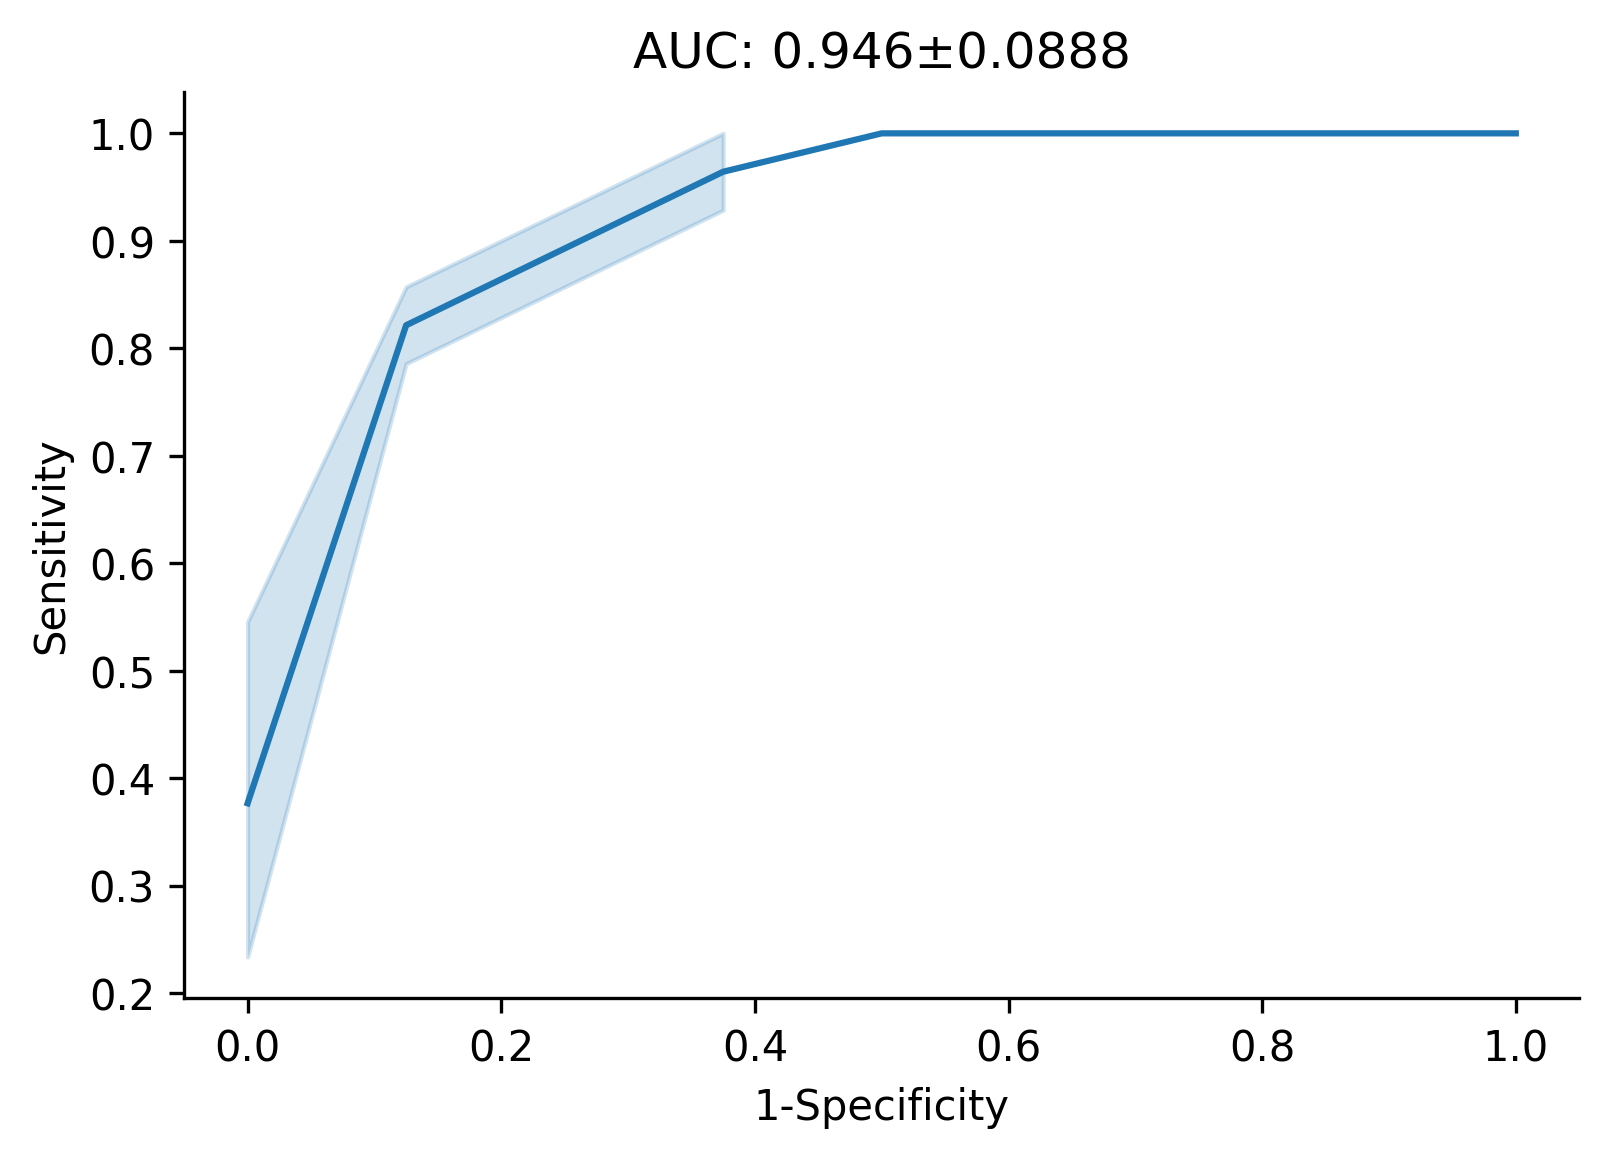

In [75]:
plt.figure()
ax=sns.lineplot('1-Specificity','Sensitivity',data=roc_df)
plt.title("AUC: {}".format(return_bootstrap_results(results,auc,2)))
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
sns.despine()

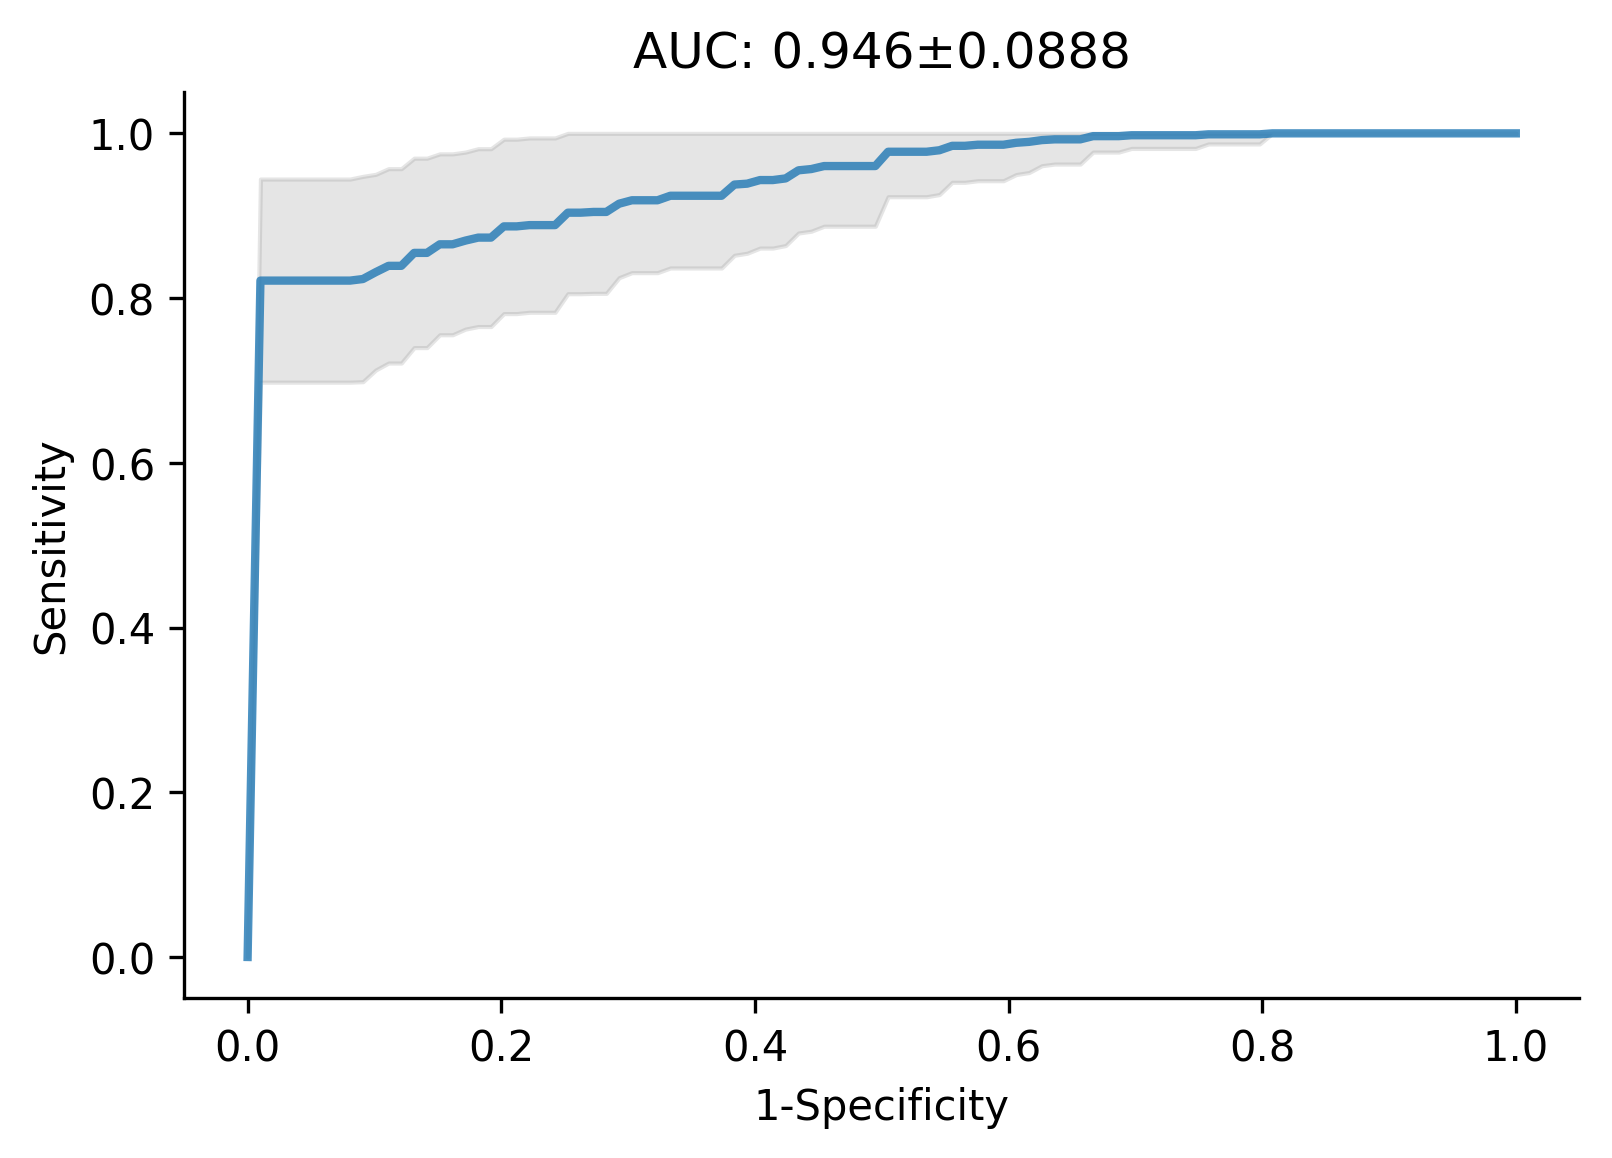

In [74]:
def bootstrap_roc(y_test, y_pred_probs,seed=0,orig=True):
    np.random.seed(seed)
    idx=np.random.choice(np.arange(len(y_test)),size=len(y_test),replace=True)
    if not orig:
        y_test=y_test.iloc[idx]
        y_pred_probs=y_pred_probs[idx]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs, drop_intermediate=False)
    roc_df = pd.DataFrame(np.vstack([fpr,tpr,thresholds]).T,columns=['1-Specificity','Sensitivity','Thresholds'])
    return roc_df
    

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs, drop_intermediate=False)
roc_df = pd.DataFrame(np.vstack([fpr,tpr,thresholds]).T,columns=['1-Specificity','Sensitivity','Thresholds'])
results=pd.DataFrame(np.vstack([y_test.values,y_pred,y_pred_probs]).T,columns=['y_true','y_pred','y_pred_probs'])
bootstrapped_roc=[bootstrap_roc(y_test, y_pred_probs,seed=i,orig=False) for i in range(100)]

mean_fpr = np.linspace(0, 1, 100)
tprs=[]
for roc in bootstrapped_roc:
    interp_tpr = np.interp(mean_fpr, roc['1-Specificity'], roc['Sensitivity'])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    
tprs=np.array(tprs)
mean_tpr=tprs.mean(0)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

fig, ax = plt.subplots()

sns.lineplot(mean_fpr, mean_tpr, #color='b',
        lw=2, alpha=.8)

ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title("AUC: {}".format(return_bootstrap_results(results,auc,2)))

sns.despine()

## Get Random Forest Model Importance

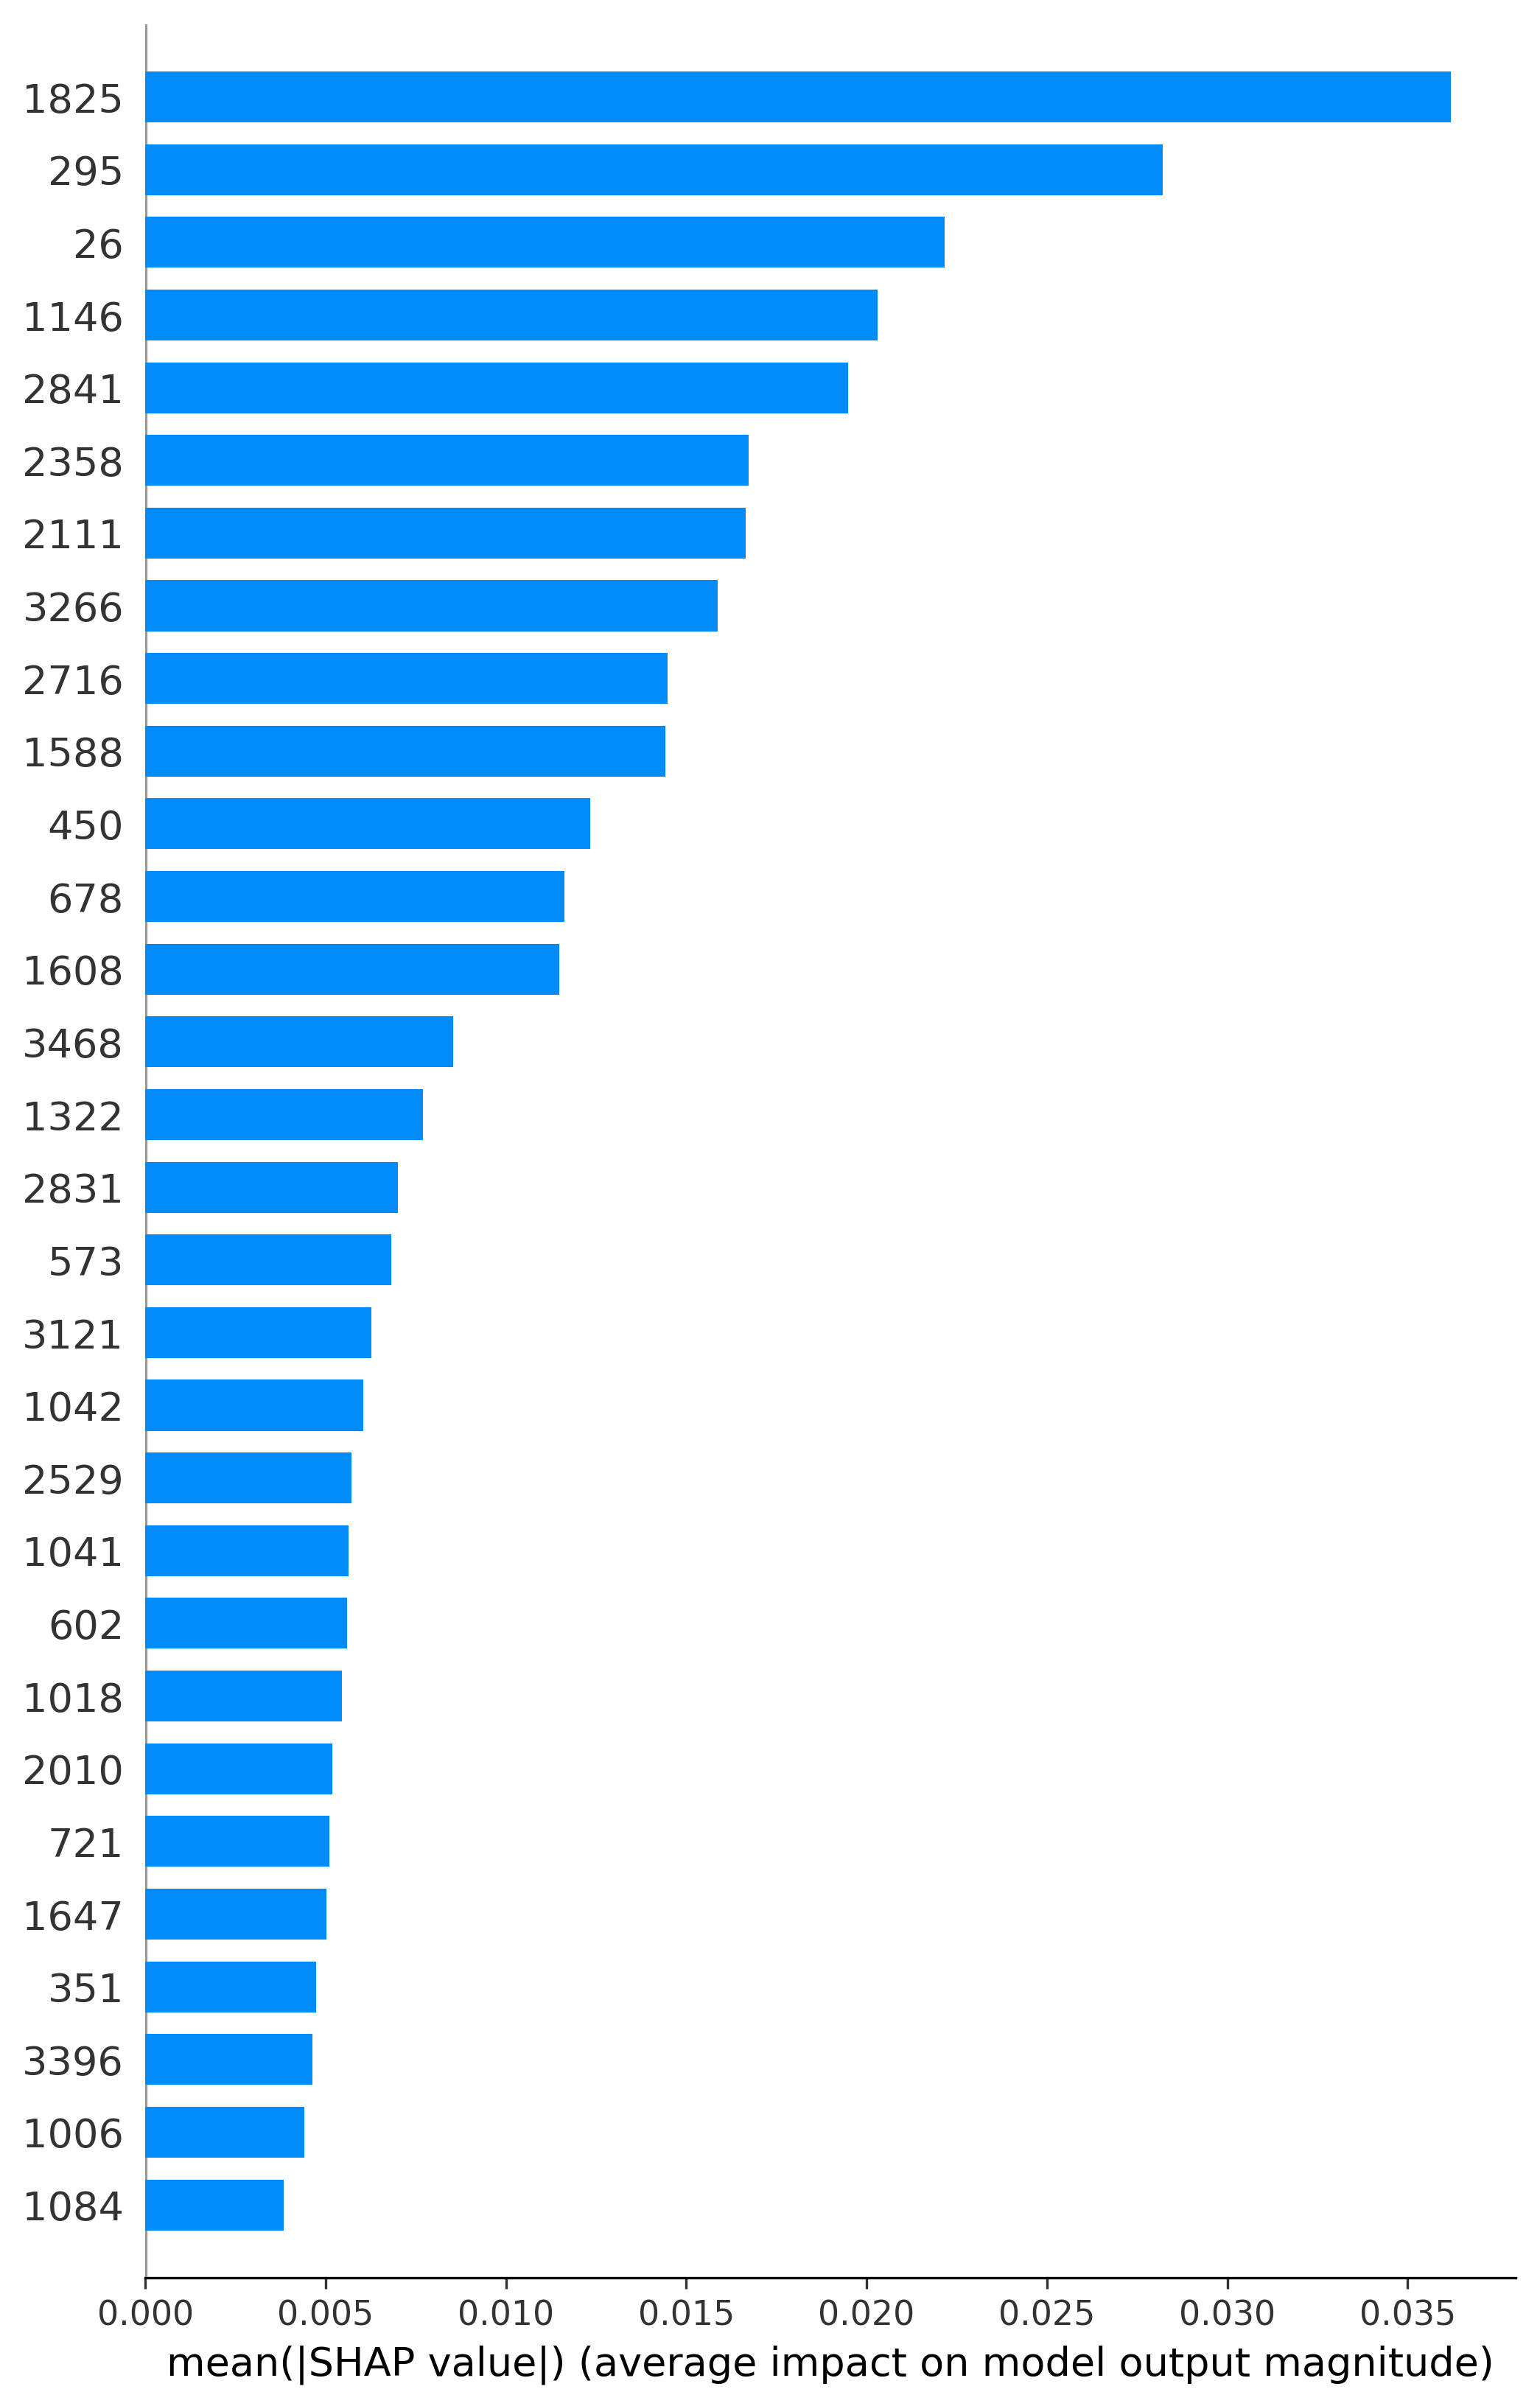

In [13]:
explainer, shap_values = run_shap(X_train, X_test, best_estimator, overall=True)

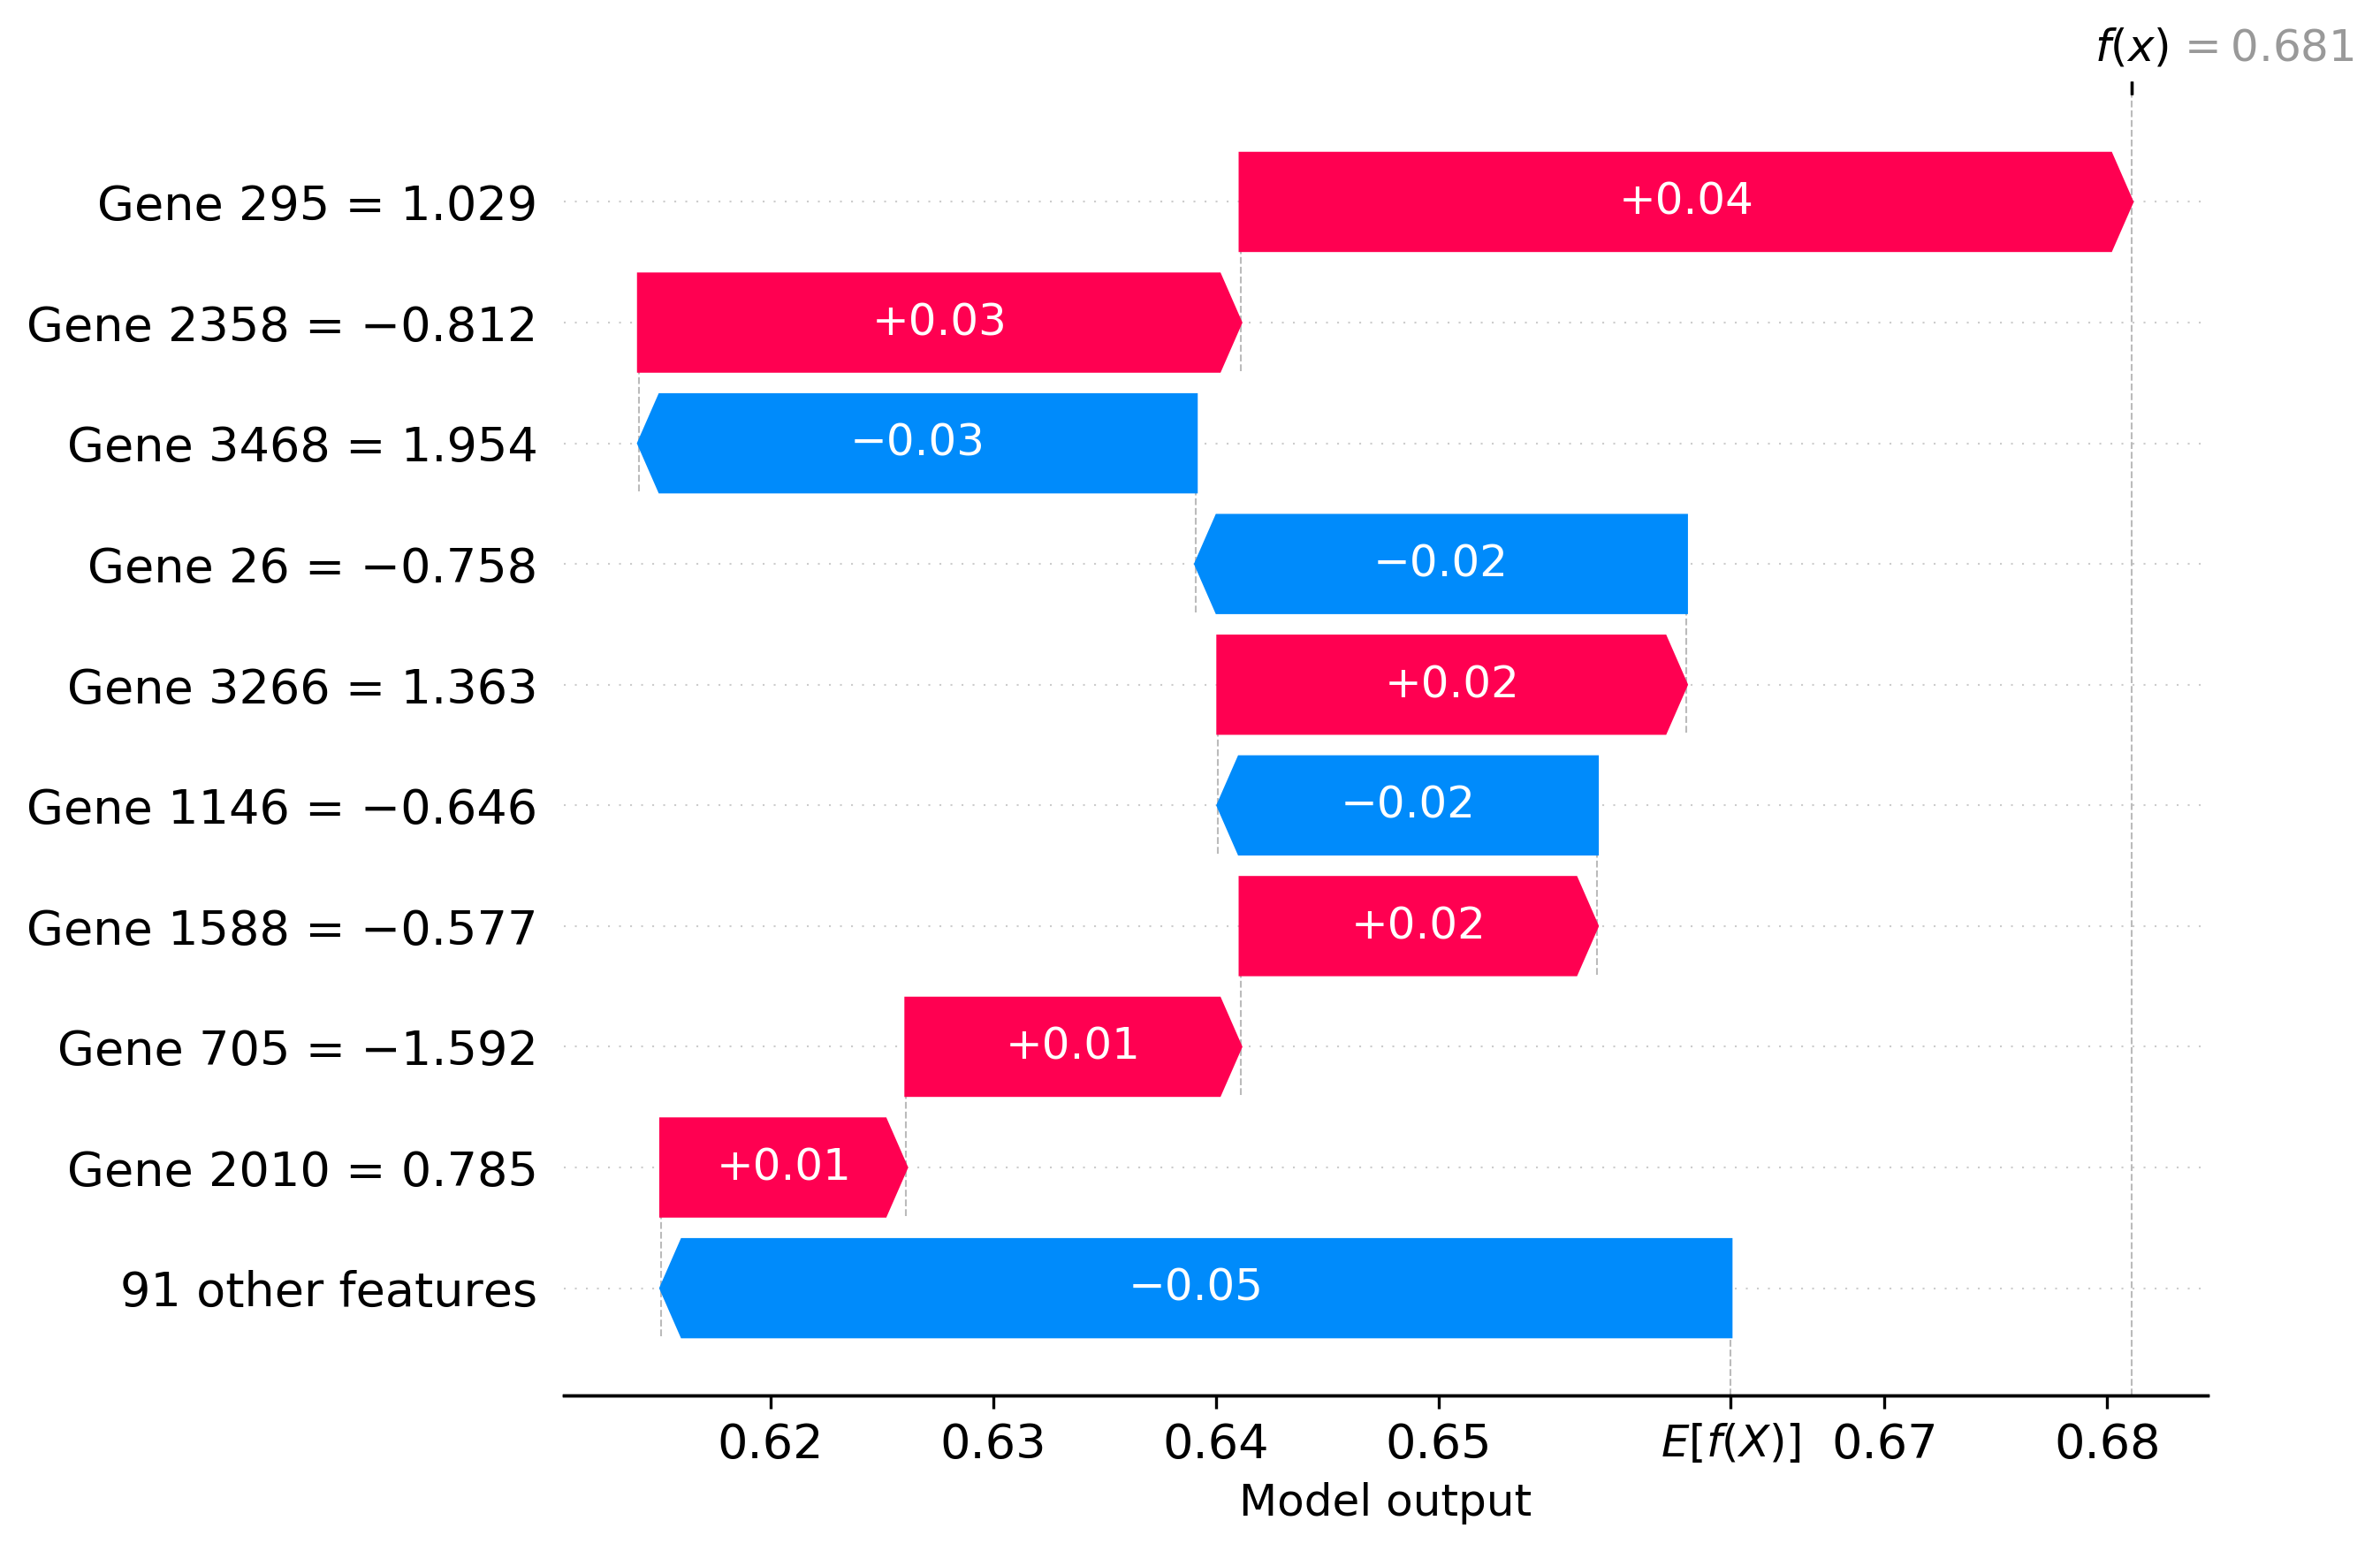

In [56]:
shap_patient(0,explainer, np.round(shap_values,3), X_test)

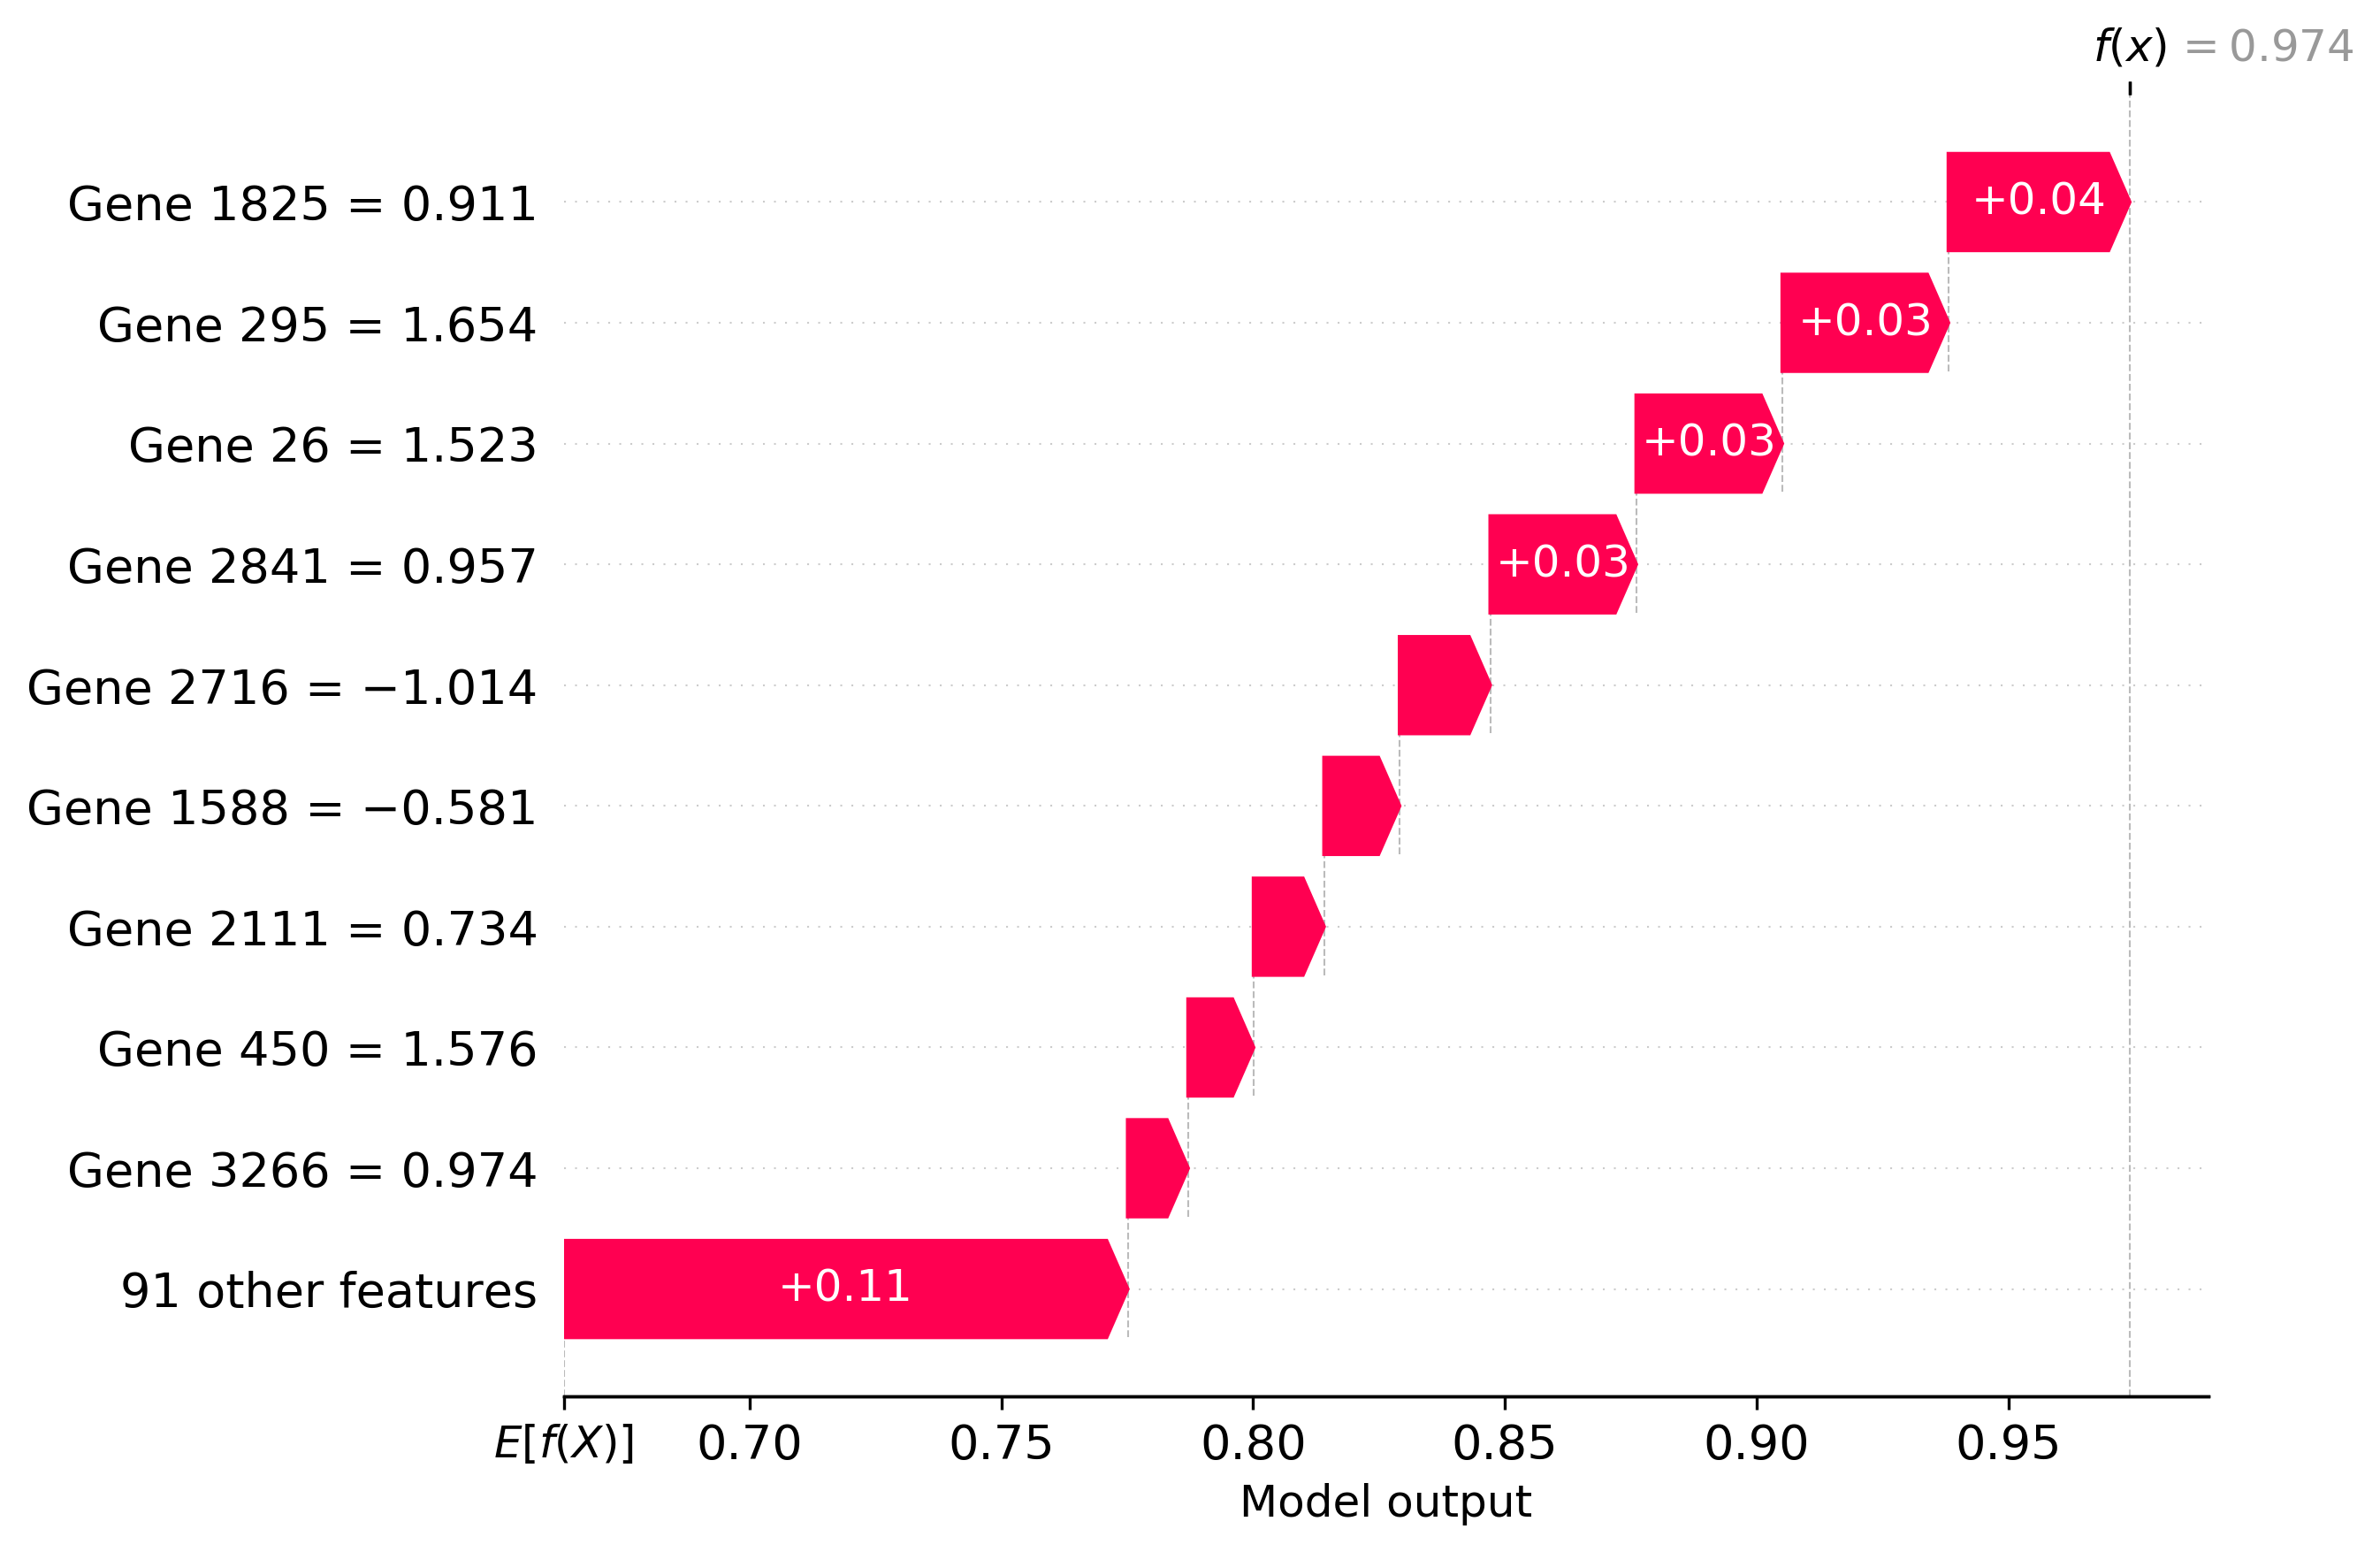

In [57]:
shap_patient(13,explainer, np.round(shap_values,3), X_test)

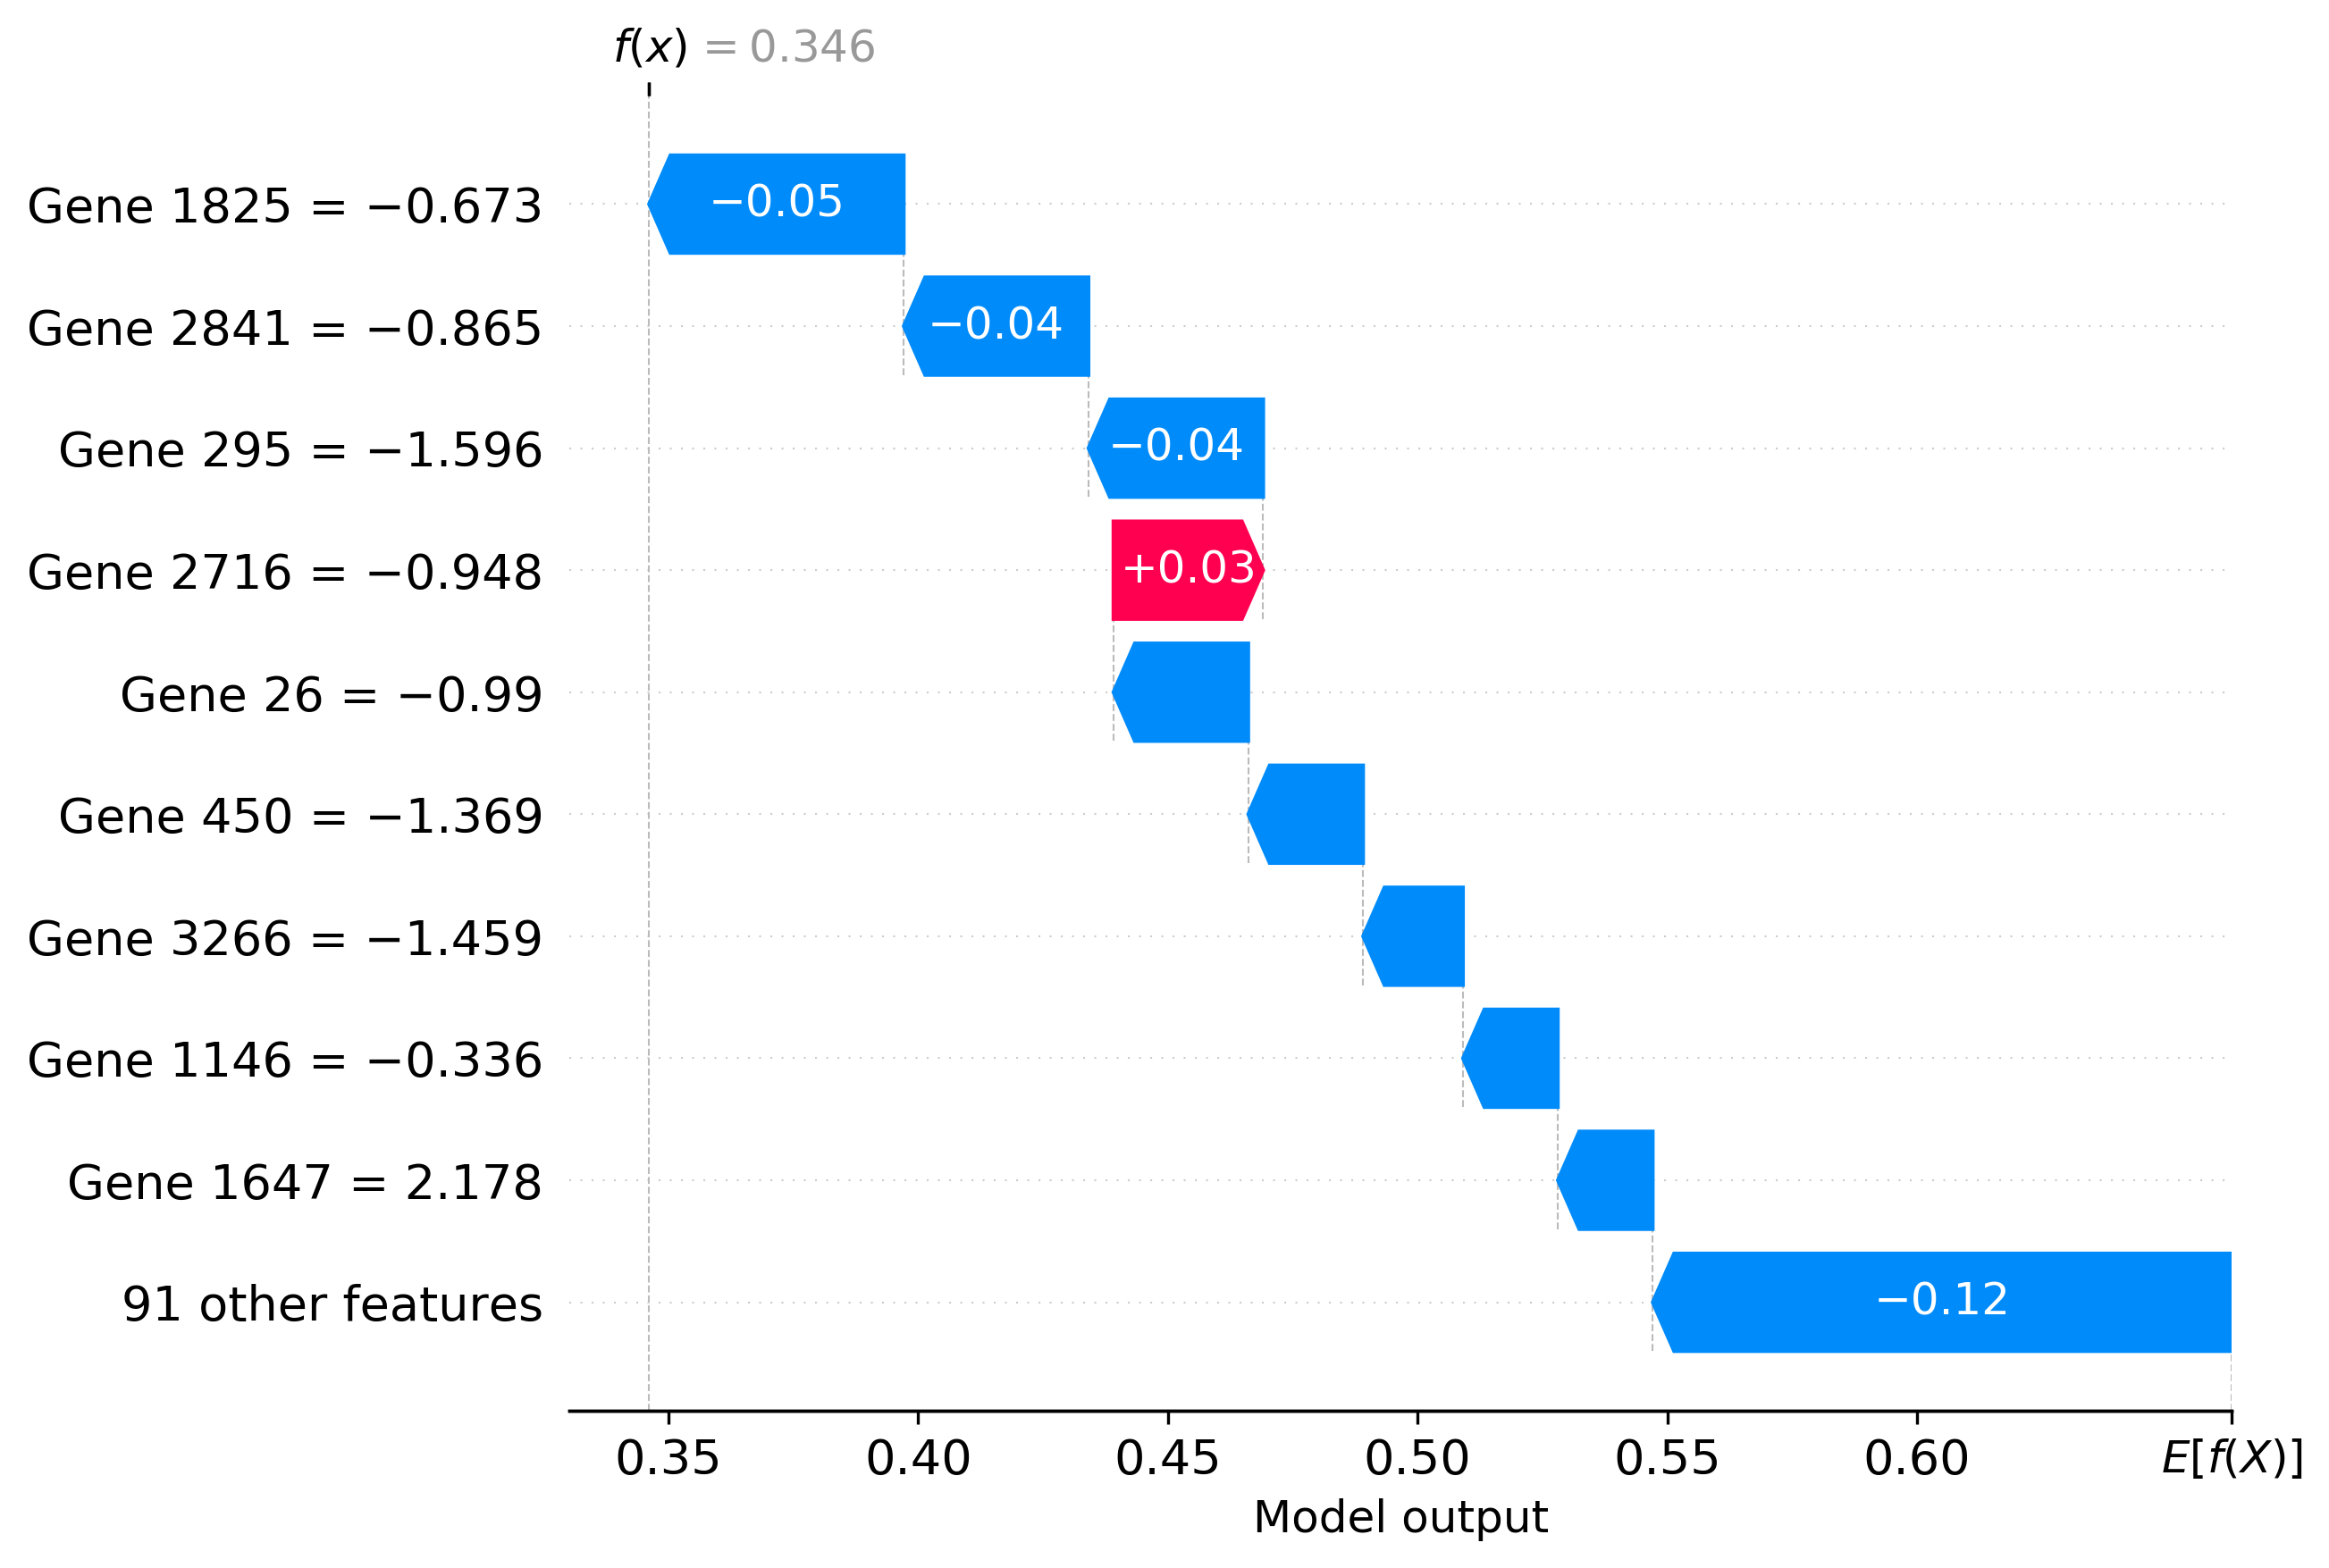

In [58]:
shap_patient(21,explainer, np.round(shap_values,3), X_test)

## Train classification SVM

In [82]:
estimator=LinearSVC
param_grid={'C':[0.01,0.1,1,10,100]}
grid_search = GridSearchCV(estimator=estimator(random_state=42,class_weight="balanced"), param_grid=param_grid, scoring='roc_auc', cv=5, verbose=False)
grid_search.fit(X_train,y_train)
best_params=grid_search.best_params_

options=best_params
options.update(dict(random_state=42,
                   class_weight="balanced"))
best_estimator=estimator(**options)
best_estimator.fit(X_train,y_train)
y_pred=best_estimator.predict(X_test)
y_pred_probs=best_estimator.decision_function(X_test)

In [83]:
print(classification_report(y_test,y_pred))
df_confusion=pd.DataFrame(confusion_matrix(y_test,y_pred))
df_confusion.index=pd.MultiIndex.from_frame(pd.DataFrame([("Prediction",x) for x in [0,1]]))
df_confusion.columns=pd.MultiIndex.from_frame(pd.DataFrame([("Reference",x) for x in [0,1]]))
df_confusion

              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.93      0.93      0.93        14

    accuracy                           0.91        22
   macro avg       0.90      0.90      0.90        22
weighted avg       0.91      0.91      0.91        22



0            Reference    
1                    0   1
0          1              
Prediction 0         7   1
           1         1  13

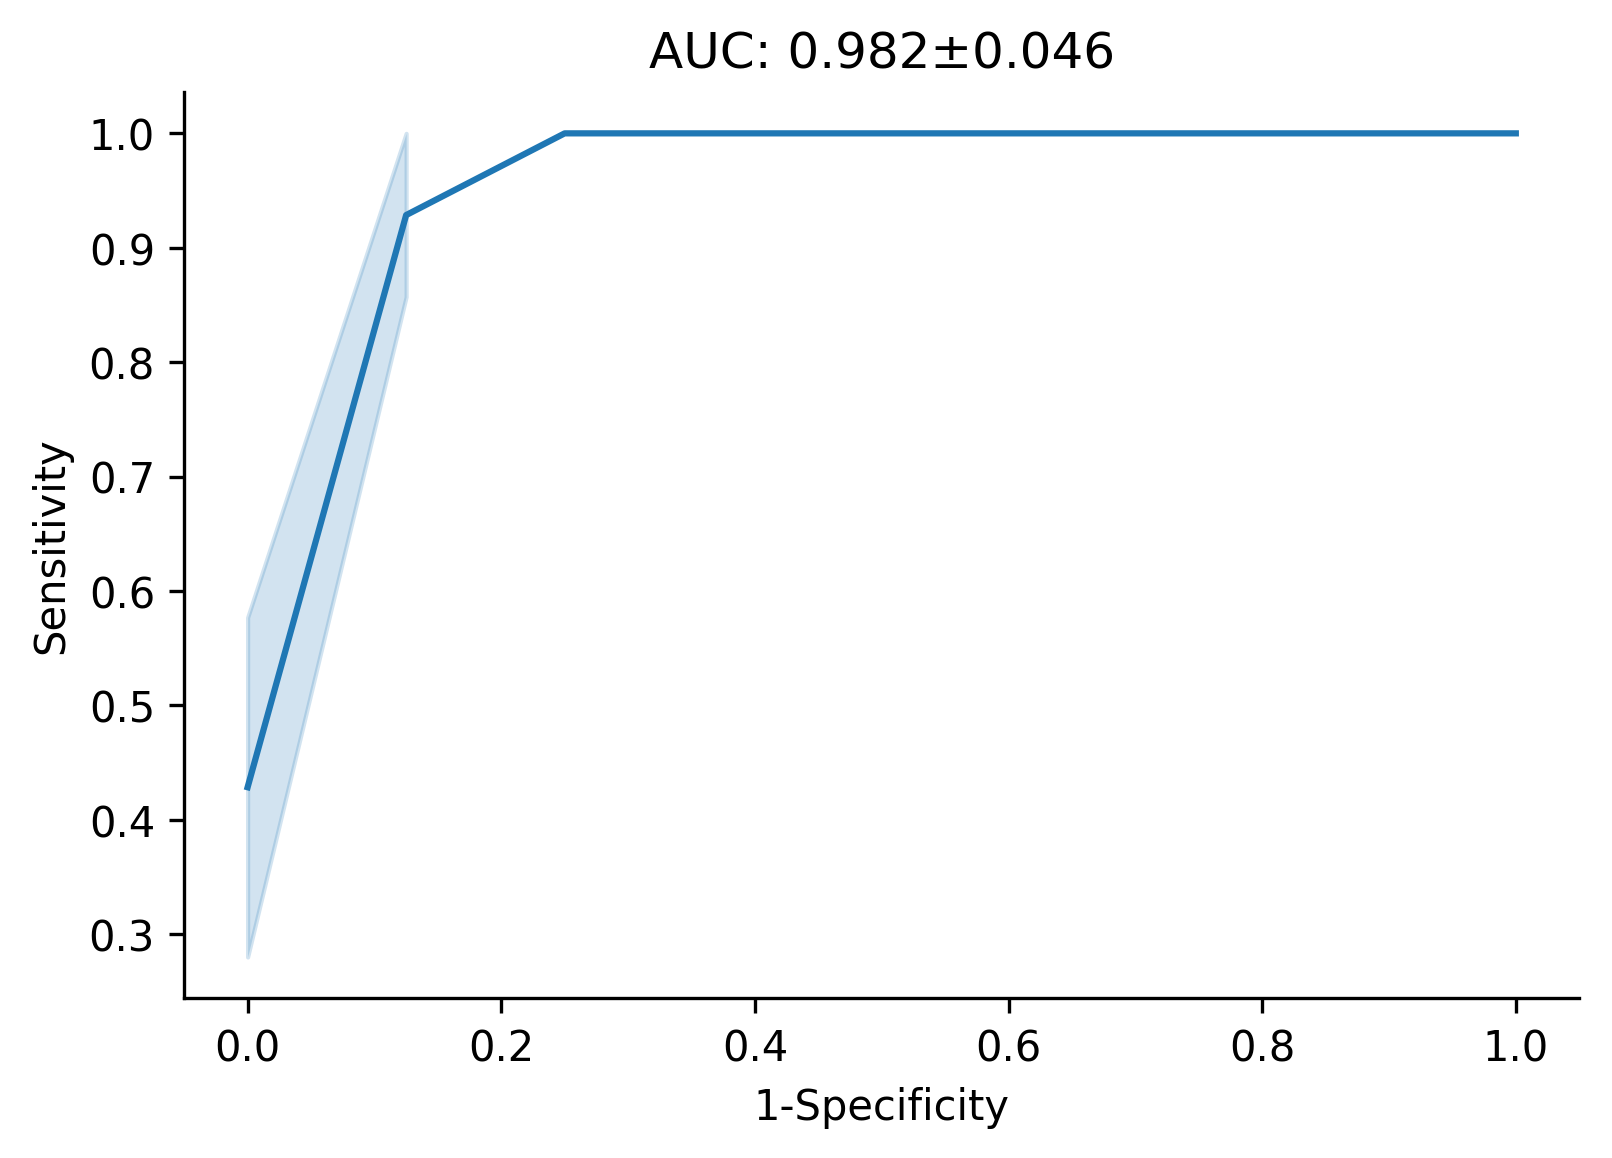

In [84]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs, drop_intermediate=False)
roc_df = pd.DataFrame(np.vstack([fpr,tpr,thresholds]).T,columns=['1-Specificity','Sensitivity','Thresholds'])
results=pd.DataFrame(np.vstack([y_test.values,y_pred,y_pred_probs]).T,columns=['y_true','y_pred','y_pred_probs'])

plt.figure()
ax=sns.lineplot('1-Specificity','Sensitivity',data=roc_df)
plt.title("AUC: {}".format(return_bootstrap_results(results,auc,2)))
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
sns.despine()

# Unsupervised Learning
- Run PCA, then cluster
# PCA

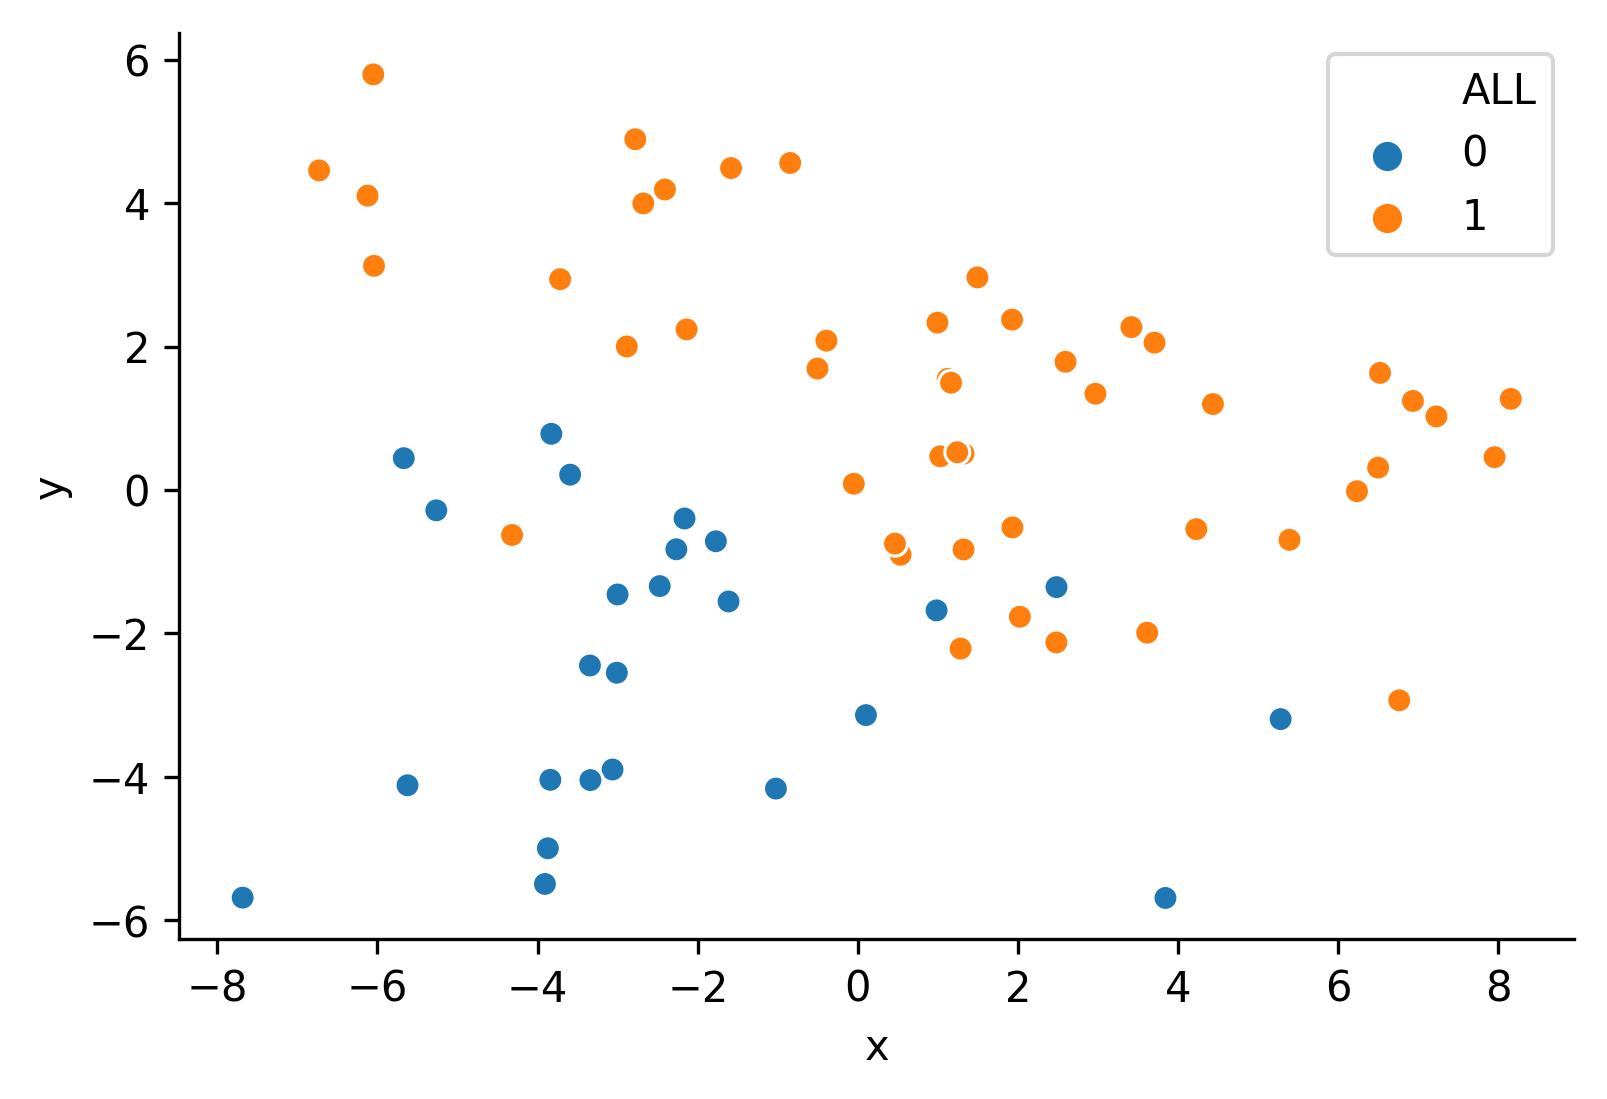

In [92]:
np.random.seed(42)
t_data=pd.DataFrame(PCA(n_components=2,random_state=42).fit_transform(X),columns=['x','y'])
t_data['ALL']=Y
sns.scatterplot(x='x',y='y',hue="ALL",data=t_data)
sns.despine()

## KMeans Clustering

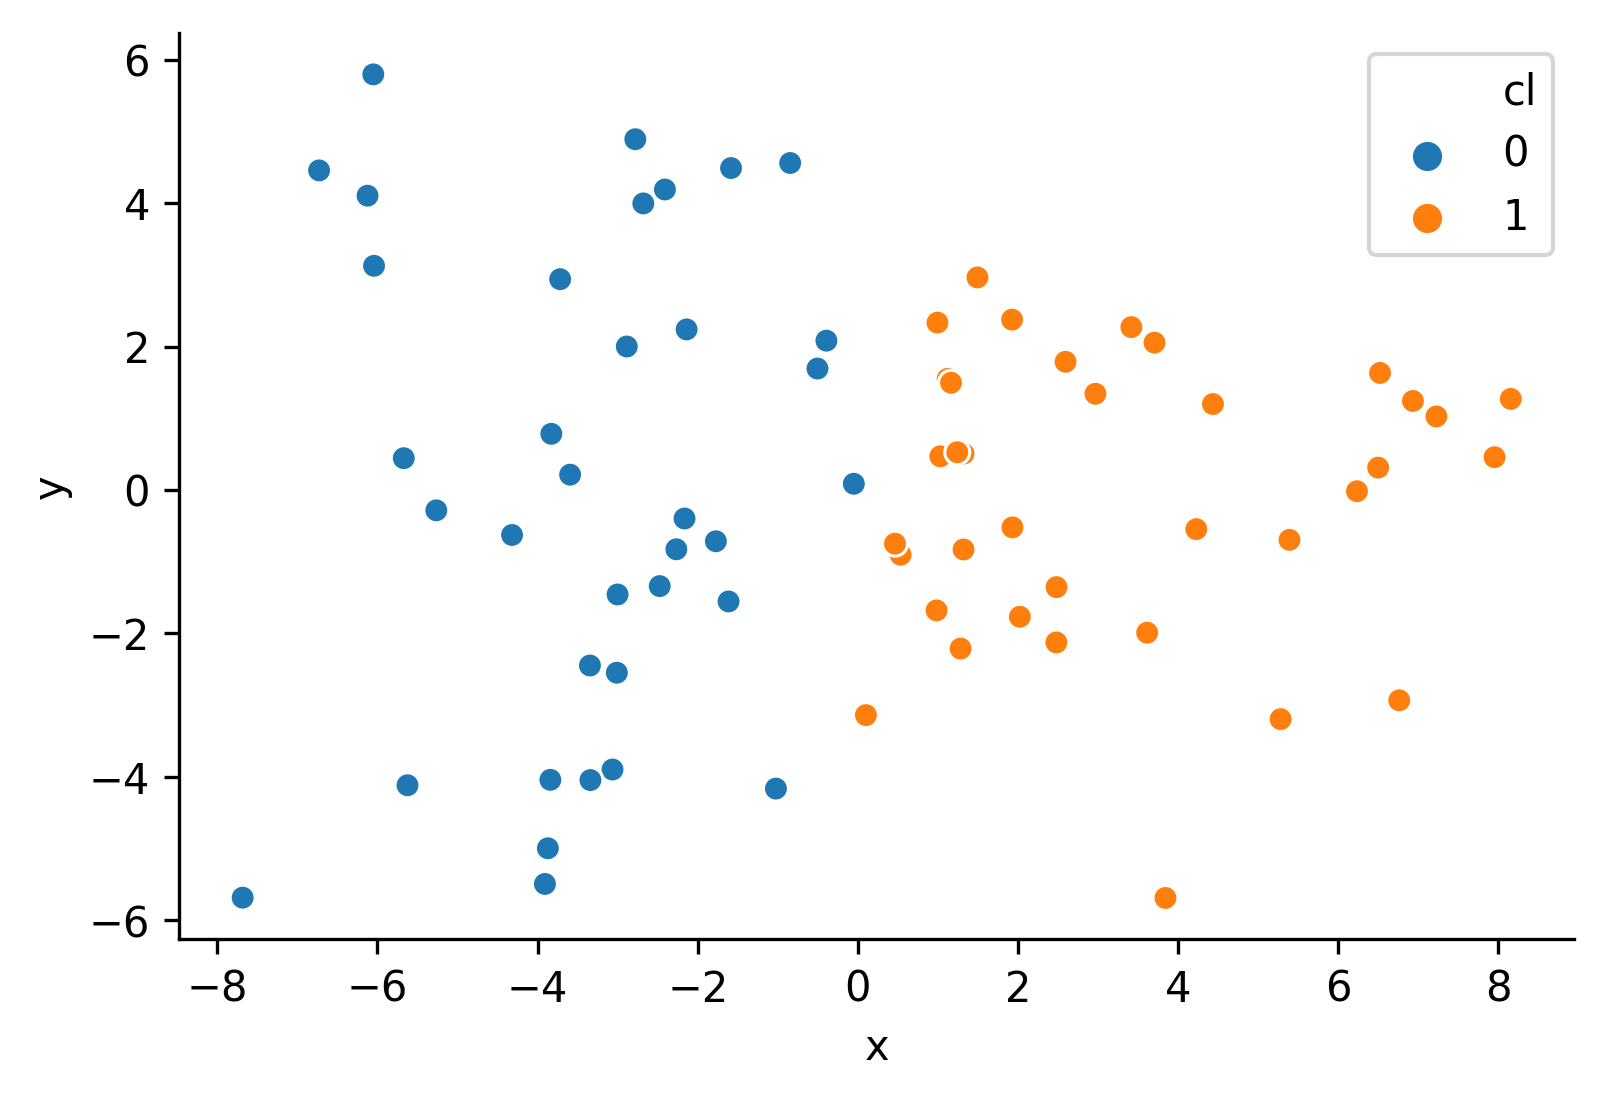

In [94]:
t_data['cl']=KMeans(n_clusters=2,random_state=42).fit_predict(t_data[['x','y']])
sns.scatterplot(x='x',y='y',hue="cl",data=t_data)
sns.despine()

## Gaussian Mixture Model

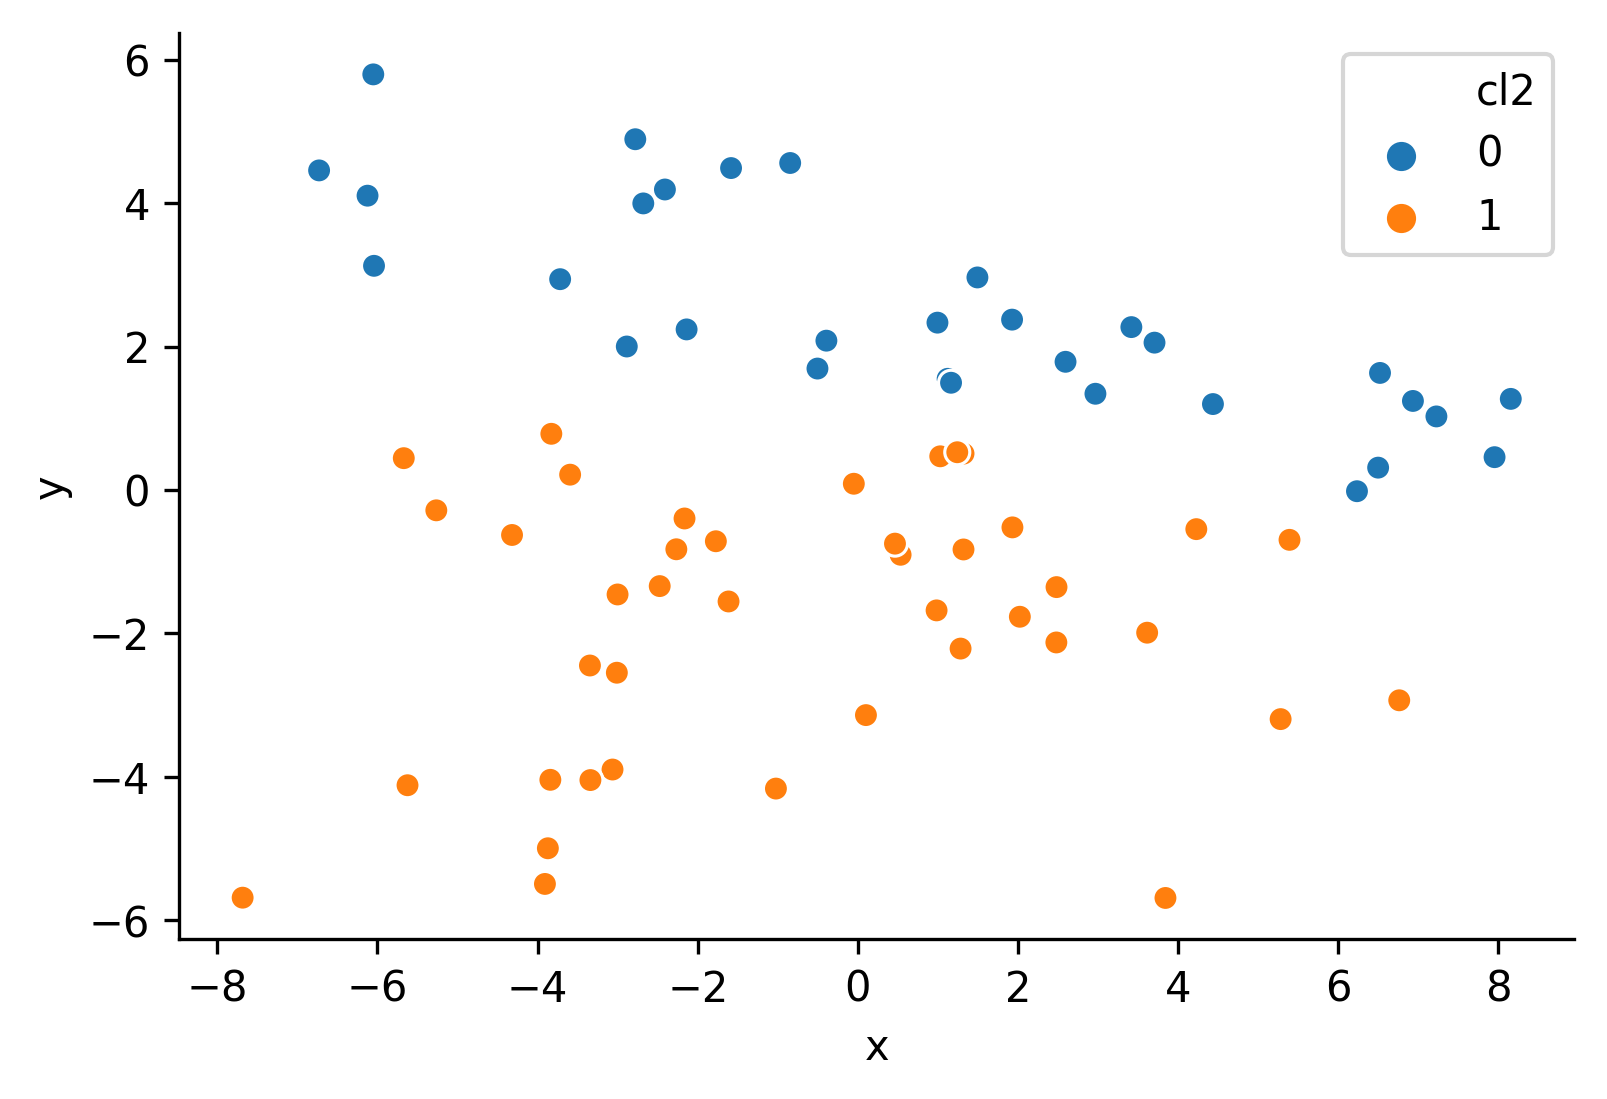

In [100]:
t_data['cl2']=GaussianMixture(n_components=2,random_state=42,init_params="random").fit_predict(t_data[['x','y']])
sns.scatterplot(x='x',y='y',hue="cl2",data=t_data)
sns.despine()

## Hierarchical Clustering

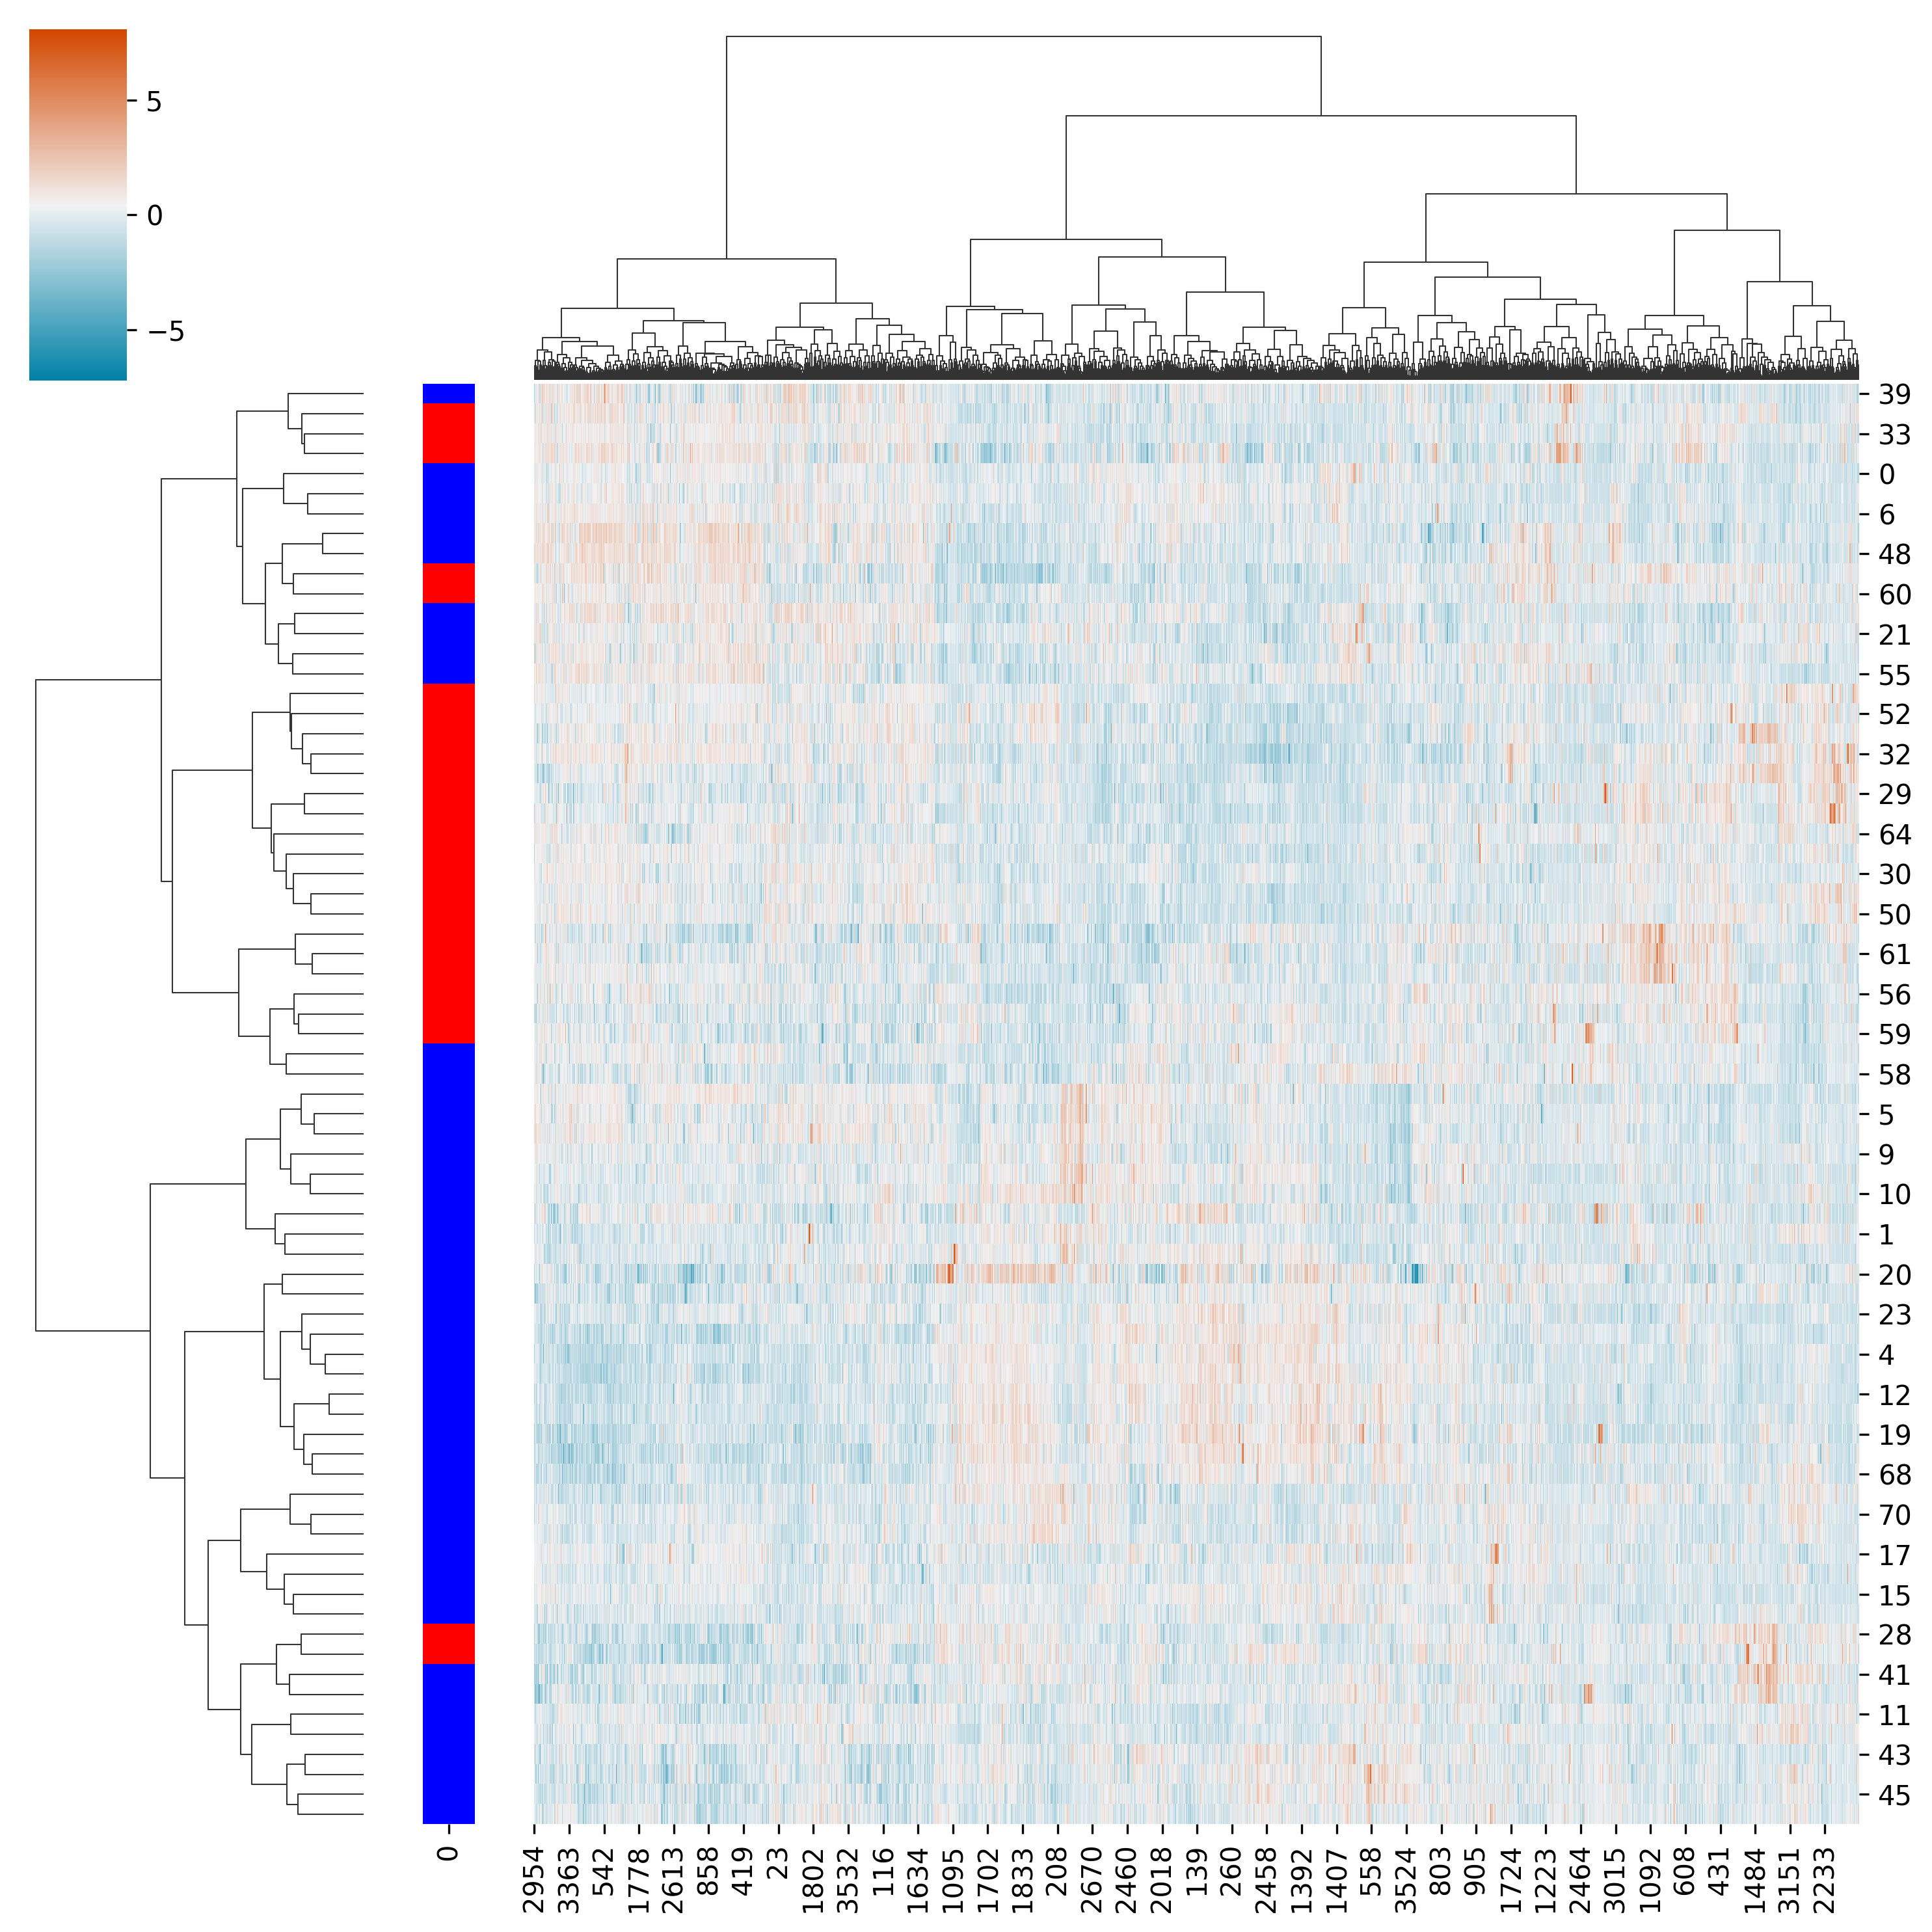

In [25]:
from sklearn.preprocessing import QuantileTransformer
import matplotlib
matplotlib.rcParams['figure.dpi']=300
cmap = dict(zip([0,1], "rb"))
row_colors=pd.Series(Y).map(cmap)
X2=data.iloc[:,1:-1]
sns.clustermap(pd.DataFrame(X2),cmap=sns.diverging_palette(230, 20, l=50, sep=1, s=100, center="light", as_cmap=True),row_colors=row_colors,metric="correlation",method="ward")
#QuantileTransformer().fit_transform(X)